# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [25]:
import dynamic_stock_model as dsm 
import copy
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd


In [2]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 1/100 # 1/100 is the actual rate

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(61)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(61)  # from 1990 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



In [3]:

def polyfit_fixed_last_point(x, y, degree=2):
    """
    Fits a polynomial of a given degree to data, forcing it through the last point.
    """
    # Define the fixed point (last point in the dataset)
    xf, yf = x[-1], y[-1]
    
    # Create the new variables
    y_prime = y - yf
    
    # Construct the design matrix for the new linear system
    # For a 2nd degree polynomial, columns are (x - xf) and (x^2 - xf^2)
    X_prime = np.vstack([x**i - xf**i for i in range(1, degree + 1)]).T
    
    # Solve the linear system for coefficients (a1, a2, ...)
    # np.linalg.lstsq solves A @ b = y for b (here, X_prime @ a_prime = y_prime)
    a_prime, residuals, rank, singular_values = np.linalg.lstsq(X_prime, y_prime, rcond=None)
    
    # Calculate a0 using the constraint equation
    a0 = yf - sum(coeff * (xf**i) for i, coeff in enumerate(a_prime, 1))
    
    # Combine coefficients into the standard order (a2, a1, a0) for np.poly1d
    # Note: np.poly1d expects [a_deg, a_deg-1, ..., a0]
    coeffs_standard_order = np.insert(a_prime, 0, a0)[::-1]
    
    return np.poly1d(coeffs_standard_order), a0, a_prime

## Initial parameters


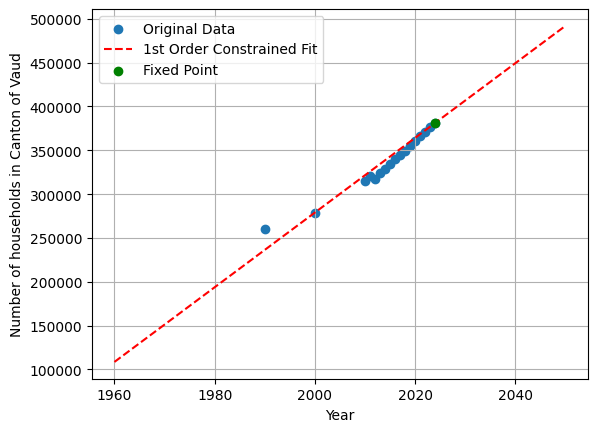

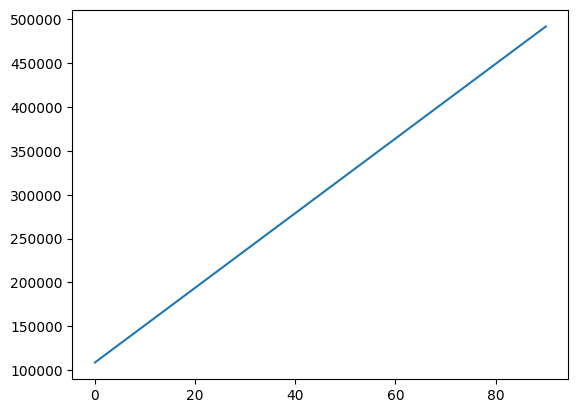

In [4]:


# Calculate housing increase over time for future years
Dates_housing=[1990, 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Housing_data=[260060, 278752, 314596, 321158, 317243, 323577, 328414,333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]

# --- Usage ---
# Sample data
x = np.array(Dates_housing)
y = np.array(Housing_data)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = np.arange(1960, 2051)
y_fit = polynomial_func(x_new)

# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit, '--',color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Year')
plt.ylabel('Number of households in Canton of Vaud')
#plt.title('First order regression for housing increase')
plt.legend()
plt.grid(True)
plt.show()



Housing=y_fit.tolist()
plt.plot(Housing)

## Create the models

[5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 61
114343.2
Dimension check GB: ('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is not present.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

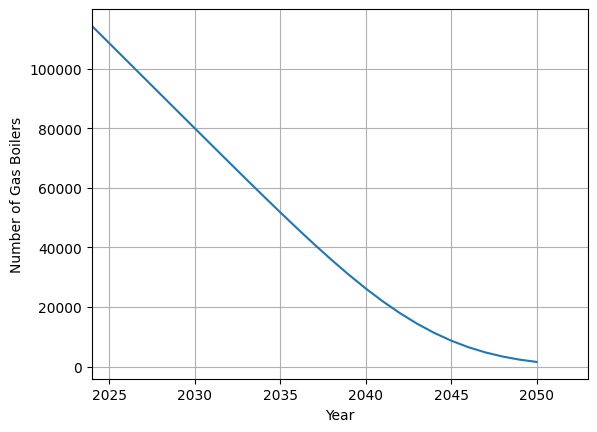

In [5]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/20]*(2025-1990)+[0]*26
print(GB_sales, len(GB_sales))
Years_GB=np.arange(1990,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)

print(housing_2024*prop_GB_2024)
check_GB=GB_DSM.dimension_check()
print("Dimension check GB:", check_GB)
# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()


# plot stock
print('GB in 2024:', GB_DSM.s[2024-2051], 'theoretical=', housing_2024*prop_GB_2024)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
#plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.xlim(2024)
#plt.hlines(housing_2024*prop_GB_2024,xmin=1989, xmax=2024, color='red', linestyles='dashed', label='2024 GB Stock Target')
#plt.legend(loc='lower right')
plt.show()



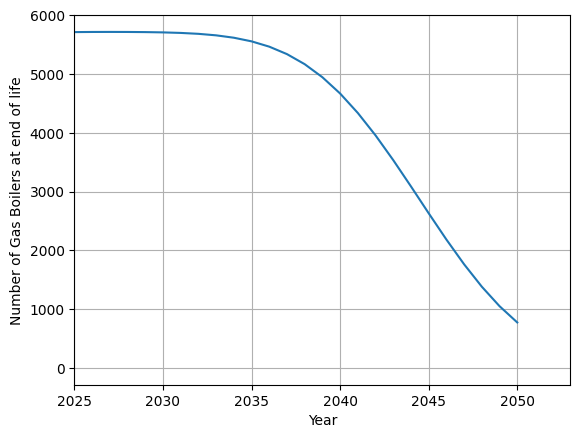

In [6]:
# plot stock

plt.grid()
plt.plot( GB_DSM.t,GB_DSM.o, label='Gas Boilers Stock')
#plt.title('Gas Boilers exports over time')
plt.xlabel('Year')
plt.xlim(2025)
plt.ylabel('Number of Gas Boilers at end of life')
plt.show()

35
HP in 2024: 64794.479999999974 theoretical= 64794.48


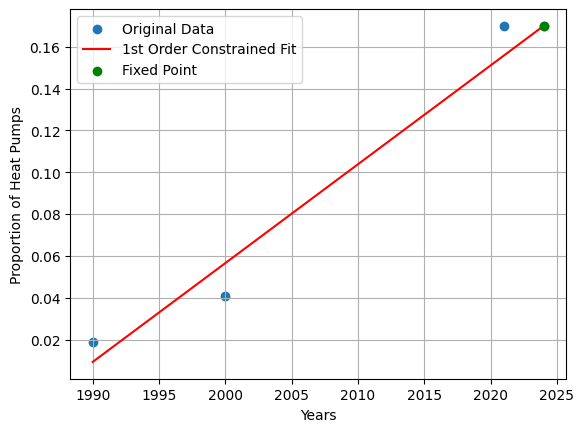

In [7]:
# Model for the heat pumps STOCK driven model
# past stock


Years_HP=np.arange(1990, 2025)
Data_past=[1990, 2000, 2021, 2024]
Data_past_HP=[1.9/100, 4.1/100, 17/100, 17/100]




# --- Usage ---
# Sample data
x = np.array(Data_past)
y = np.array(Data_past_HP)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = Years_HP
y_fit = polynomial_func(x_new)
print(len(y_fit))
# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit.clip(min=0), color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Years')
plt.ylabel('Proportion of Heat Pumps')
#plt.title('First Order Polynomial Regression Forcing Last Point')
plt.legend()
plt.grid(True)


# Print coefficients
# print(f"Coefficients (a0, a1, a2): {a0}, {a_prime[0]}, {a_prime[1]}")
# print(f"Function: {polynomial_func}")


HP_stock_i=[x*h for x,h in zip(y_fit.clip(min=0).tolist(),Housing[30:])]
print('HP in 2024:', HP_stock_i[-1], 'theoretical=', housing_2024*prop_HP_2024)

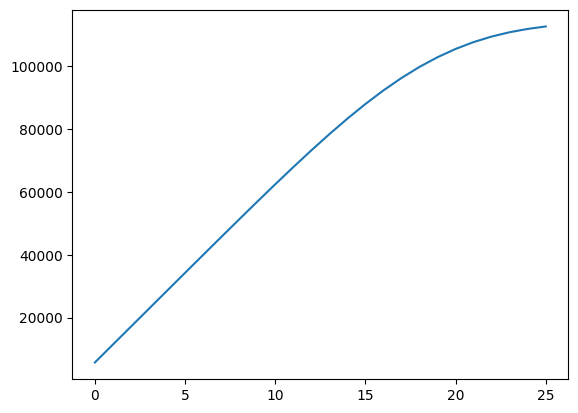

In [8]:
# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024) 
Housing_increase=[h-housing_2024 for h in Housing]

GB_to_HP=np.array(GB_DSM.o)[-26:].cumsum()
plt.plot(GB_to_HP)
HP_stock_f = [a + b + (prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_to_HP,Housing_increase[-(2050-2024):])]  #  2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = np.arange(1990,2051), 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow is not present.<br>Total stock is present with 61 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% of Heat pumps')

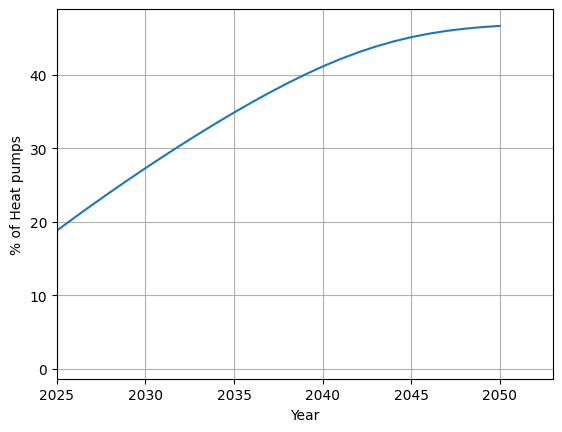

In [9]:
# compute stock driven model to get inflow
check_HP=HP_DSM.dimension_check()
print(check_HP)
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()

O1=HP_DSM.compute_outflow_total()
# plot stock

plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(Housing[30:])*100, label='Heat pump Stock') #[-16] for 2035
#plt.title('Heat pump Stock over time (% of housing in 2035)')
plt.xlabel('Year')
#plt.hlines(50,xmin=2000, xmax=2050, color='red', linestyles='dashed', label='50% Target for 2035')
plt.xlim(2025)
plt.ylabel('% of Heat pumps')

Text(0, 0.5, 'Heat pumps import')

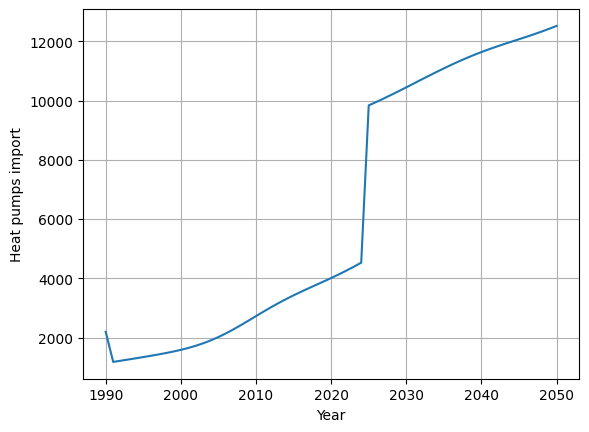

In [10]:
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')
#plt.title('Heat pump imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps import')

## Calculating an incentive to buy HP 
Target of 55% in 2035(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

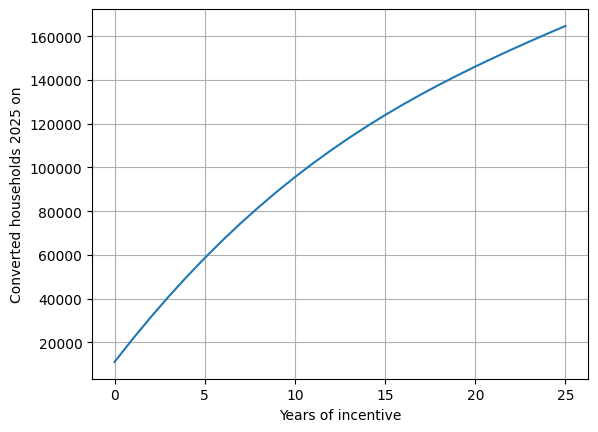

In [11]:
incentive_HP=3.5/100 #<- result: percentage of households that don't have converted yet but will convert due to incentives

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(max(incentive_HP*(Housing[-26+i]-HP_stock[-26+i]-Converted_households[-1])+Converted_households[-1],Converted_households[-1]))
plt.plot(Converted_households)
plt.ylabel("Converted households 2025 on")
plt.xlabel('Years of incentive')
plt.grid()
HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-26:],Converted_households)]




83579.361561897


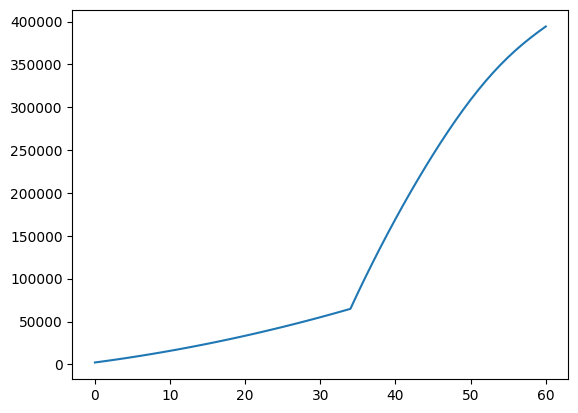

In [12]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
print(HP_stock_f1[0])
plt.plot(HP_stock1)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = np.arange(1990, 2051), 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

57.20894949231501


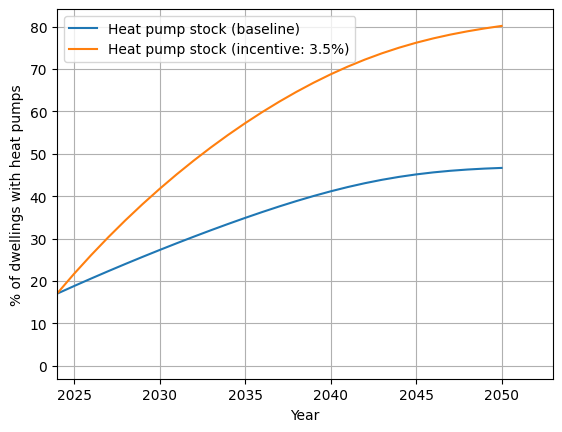

In [13]:
# compute stock driven model to get inflow (si pas déjà fait avant)
HP_inc = HP_DSM_incentive.compute_stock_driven_model()
S_inc  = HP_DSM_incentive.compute_stock_total()
O_inc  = HP_DSM_incentive.compute_outflow_total()
check_HP_inc = HP_DSM_incentive.dimension_check()

Housing_array = np.array(Housing)  # same lenght que HP_DSM.t = 1990–2050

# plot stock

plt.grid()
plt.plot(HP_DSM.t,100 * np.array(HP_DSM.s) / Housing_array[30:],label='Heat pump stock (baseline)')
plt.plot(
    HP_DSM_incentive.t,100 * np.array(HP_DSM_incentive.s) / Housing_array[30:],label=f'Heat pump stock (incentive: {incentive_HP*100:.1f}%)')
#plt.title('Heat pump stock over time (% of dwellings)')
plt.xlim(2024)
plt.xlabel('Year')
plt.ylabel('% of dwellings with heat pumps')
plt.legend()
print(np.array(HP_DSM_incentive.s)[-16]*100 / Housing_array[-16])


In [14]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
O_inc=HP_DSM_incentive.compute_outflow_total()
check_HP_inc=HP_DSM_incentive.dimension_check()

print(check_HP_inc)


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is present with 61 years.<br>Stock by cohorts is present with 61 years and 61 cohorts.<br>Total outflow is present with 61 years.<br>Outflow by cohorts is present with 61 years and 61 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, 'Heat pump import')

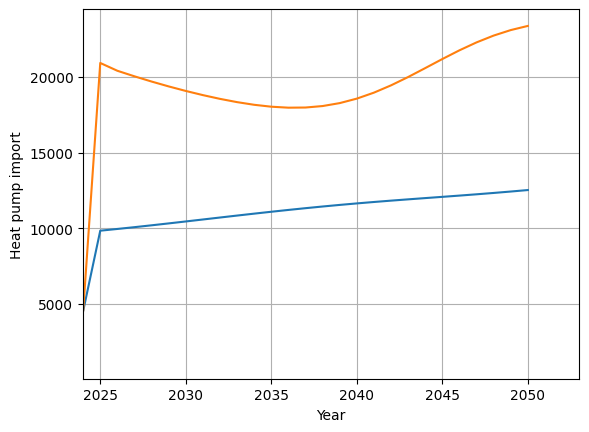

In [15]:

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')

plt.plot( HP_DSM_incentive.t,HP_DSM_incentive.i, label='Heat pump import with incentive')
#plt.title('Heat pump imports')
plt.xlabel('Year')
plt.xlim(2024)
plt.ylabel('Heat pump import')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [16]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² par an

# Heat pump
COP=3.26 # Coefficient of performance

# Gas boiler
LHV_gas= 50 # MJ/kg
efficiency_GB=0.9

# emissions
e_elec= 0.0273 #kgCO2/kWh
e_gas_boiler= 0.0754 #kgCO2/MJ  !!
e_HP_manufacture=1010+81-175 #kgCO2/unit (assembly+transport+End of Life)

# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg

## Electricity imports

In [17]:
# electricity needs per household

elec_need_HP= S_household*cons_surface/COP  #kWh/year

# electricity needs total per year
Elec_imports=np.array(HP_DSM.s)*elec_need_HP/1000000  #GWh/year
Elec_imports_inc=np.array(HP_DSM_incentive.s)*elec_need_HP/1000000  #GWh/year
print(Elec_imports)
print(Elec_imports_inc)

[  1.9169291    2.94591727   4.01009788   5.10947091   6.24403638
   7.41379428   8.6187446    9.85888736  11.13422256  12.44475018
  13.79047023  15.17138272  16.58748764  18.03878499  19.52527477
  21.04695698  22.60383162  24.1958987   25.8231582   27.48561014
  29.18325451  30.91609131  32.68412054  34.48734221  36.3257563
  38.19936283  40.10816179  42.05215318  44.031337    46.04571325
  48.09528193  50.18004305  52.29999659  54.45514257  56.64548098
  63.38813369  70.13287776  76.87824191  83.62298598  90.36563869
  97.10399499 103.83449771 110.55144748 117.24602123 123.90513761
 130.51028469 137.03651167 143.45185946 149.71753584 155.78909877
 161.61878145 167.15888089 172.3658803  177.20474726 181.65271772
 185.70189505 189.36017589 192.65032426 195.60737262 198.27483773
 200.70042258]
[  1.9169291    2.94591727   4.01009788   5.10947091   6.24403638
   7.41379428   8.6187446    9.85888736  11.13422256  12.44475018
  13.79047023  15.17138272  16.58748764  18.03878499  19.52527

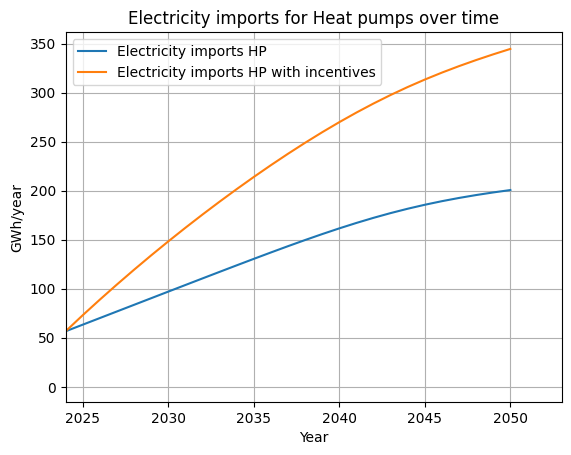

In [18]:
# plot electricity imports
plt.grid()
plt.plot( HP_DSM.t,Elec_imports, label='Electricity imports HP')
plt.plot( HP_DSM_incentive.t,Elec_imports_inc, label='Electricity imports HP with incentives')
plt.title('Electricity imports for Heat pumps over time')
plt.xlabel('Year')
plt.xlim(2024)
plt.ylabel('GWh/year')
plt.legend()

## Gas imports

In [19]:
# Gas needs per household
gas_need_GB= S_household*cons_surface/(LHV_gas*1000*efficiency_GB)*3600  #kg/year

# gas needs total per year
Gas_imports=np.array(GB_DSM.s[20:])*gas_need_GB/1000000  #kt/year


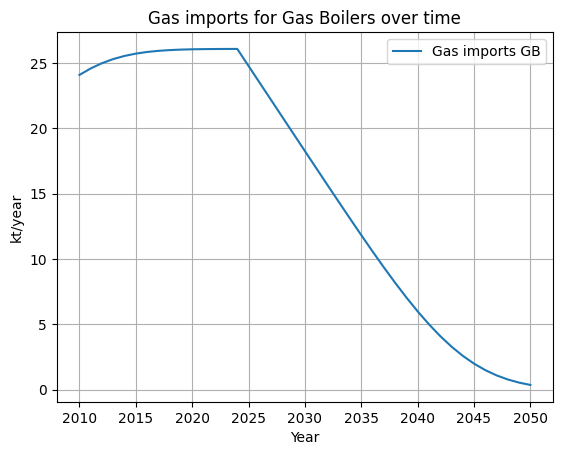

In [20]:
# plot gas imports
plt.grid()
plt.plot( GB_DSM.t[20:],Gas_imports, label='Gas imports GB')
plt.title('Gas imports for Gas Boilers over time')
plt.xlabel('Year')
plt.ylabel('kt/year')
plt.legend()

## $CO_2$ emissions
We use scope 3

In [21]:
# ---- HP EMISSIONS (corrected units) ----
# Elec_imports = GWh
# Convert to kWh: 1 GWh = 1,000,000 kWh

CO2_emissions_HP = (Elec_imports * 1_000_000 * e_elec + HP_DSM.i * e_HP_manufacture) / 1000
# result: tonnes CO2/year

CO2_emissions_HP_inc = (Elec_imports_inc * 1_000_000 * e_elec + HP_DSM_incentive.i * e_HP_manufacture) / 1000

# household heat demand
E_h = 2850  # kWh

# fuel energy needed
fuel_energy_kWh = E_h / efficiency_GB

# convert kWh -> MJ
fuel_energy_MJ = fuel_energy_kWh * 3.6


# GB $CO_2$ emissions
CO2_emissions_GB= S_household*cons_surface*GB_DSM.s[20:]*e_gas_boiler*1000 #tCO2/year


t = np.arange(2024, 2051)



In [22]:

#  Household energy demand

S_household = 95            # m² average
cons_surface = 30           # kWh/m² per year
E_household = S_household * cons_surface   # 2850 kWh per year
print(f"[DEBUG] E_household: {E_household} kWh/year")  # Debug


# Gas boiler parameters

efficiency_GB = 0.9
LHV_MJ = 50                 # MJ/kg
LHV_kWh = LHV_MJ * 0.278    # → 13.9 kWh/kg
e_gas_MJ = 0.0754           # kg CO₂ per MJ burned
print(f"[DEBUG] LHV_kWh: {LHV_kWh} kWh/kg")  # Debug

# Gas needed per household
gas_need_GB = E_household / (efficiency_GB * LHV_kWh)     # kg gas/year
print(f"[DEBUG] gas_need_GB: {gas_need_GB} kg/year")  # Debug

# Emissions per kg gas
co2_per_kg_gas = LHV_MJ * e_gas_MJ                        # kg CO₂ per kg gas
print(f"[DEBUG] co2_per_kg_gas: {co2_per_kg_gas} kg CO2/kg")  # Debug

# Annual emission per household
co2_gasboiler_household = gas_need_GB * co2_per_kg_gas     # kg CO₂/year
print(f"[DEBUG] co2_gasboiler_household: {co2_gasboiler_household} kg CO2/year")  # Debug

# Heat pump parameters

COP = 3.26
SCOP = 3.6
e_elec = 0.0273                 # kg CO₂ / kWh (Swiss grid)
e_HP_manufacture = 1010 + 81 - 175   # kg CO₂ per HP manufactured
print(f"[DEBUG] e_HP_manufacture: {e_HP_manufacture} kg CO2")  # Debug

# Electricity per household
elec_need_HP = E_household / SCOP
print(f"[DEBUG] elec_need_HP: {elec_need_HP} kWh/year per household")  # Debug


#  Imported time-series (your model)

# Electricity imports for HP (GWh)
Elec_imports = np.array(HP_DSM.s) * elec_need_HP / 1e6
Elec_imports_inc = np.array(HP_DSM_incentive.s) * elec_need_HP / 1e6


#  annual HP emissions (tonnes CO₂/year)

CO2_emissions_HP = (Elec_imports * 1_000_000 * e_elec + HP_DSM.i * e_HP_manufacture) / 1000
CO2_emissions_HP_inc = (Elec_imports_inc * 1_000_000 * e_elec + HP_DSM_incentive.i * e_HP_manufacture) / 1000
print(f"[DEBUG] CO2_emissions_HP (t/year): {CO2_emissions_HP}")  # Debug
# print(f"[DEBUG] CO2_emissions_HP_inc (t/year): {CO2_emissions_HP_inc}")  # Debug

#  GB emissions (tonnes CO₂/year)

CO2_emissions_GB = co2_gasboiler_household * GB_DSM.s / 1000    # t CO₂/year
print(f"[DEBUG] CO2_emissions_GB (t/year): {CO2_emissions_GB}")  # Debug


# Cumulative emissions (2025–2050)

cum_HP = np.cumsum(CO2_emissions_HP)             # kt
cum_HP_inc = np.cumsum(CO2_emissions_HP_inc)     # kt
cum_GB = np.cumsum(CO2_emissions_GB)             # kt


[DEBUG] E_household: 2850 kWh/year
[DEBUG] LHV_kWh: 13.900000000000002 kWh/kg
[DEBUG] gas_need_GB: 227.8177458033573 kg/year
[DEBUG] co2_per_kg_gas: 3.7699999999999996 kg CO2/kg
[DEBUG] co2_gasboiler_household: 858.872901678657 kg CO2/year
[DEBUG] e_HP_manufacture: 916 kg CO2
[DEBUG] elec_need_HP: 791.6666666666666 kWh/year per household
[DEBUG] CO2_emissions_HP (t/year): [ 2055.90091283  1151.09379361  1214.46736296  1278.90276759
  1344.56003396  1411.7047801   1480.75572887  1552.33839434
  1627.3356542   1706.92004574  1792.54805729  1885.8961557
  1988.72445511  2102.66804993  2228.97659321  2368.24478732
  2520.19255559  2683.55609679  2856.13526545  3035.01022579
  3216.89921651  3398.59208638  3577.37341611  3751.35177819
  3919.63704052  4082.34678359  4240.46289812  4395.5882935
  4549.66472785  4704.70635965  4862.58559345  5024.88633341
  5192.82194514  5367.20486901  5548.4521408  10581.21387531
 10852.46205102 11127.71059351 11406.70113125 11688.76558055
 11972.97222859 1

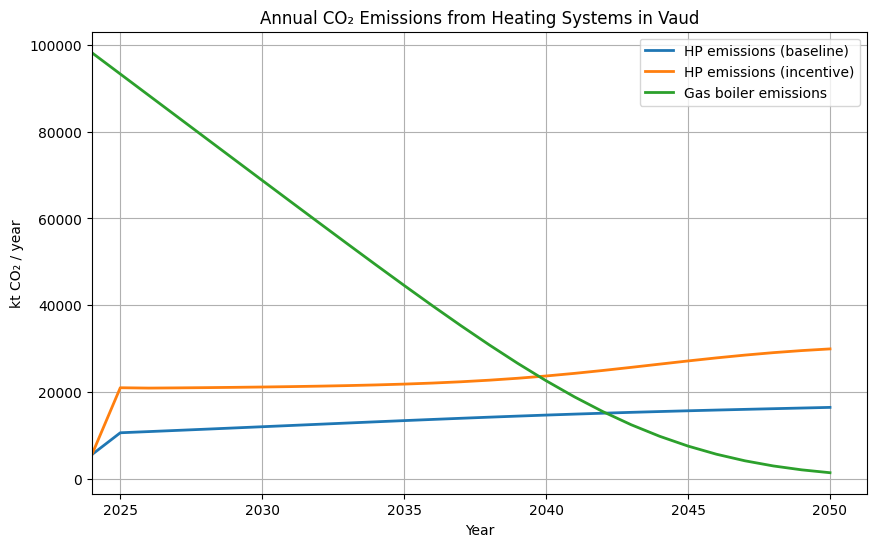

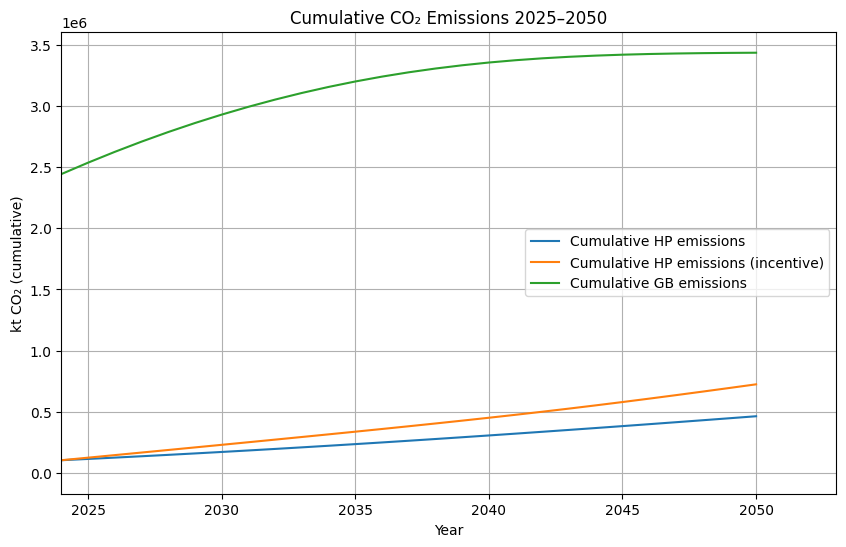

Gas boiler emissions 2025 (kt CO2): 97.9115107913669
Gas boiler from model 2025 (kt CO2): 4910.31379856115


In [23]:
#  PLOT — Annual emissions

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(t, CO2_emissions_HP[-27:], label="HP emissions (baseline)", linewidth=2)
plt.plot(t, CO2_emissions_HP_inc[-27:], label="HP emissions (incentive)", linewidth=2)
plt.plot(t, CO2_emissions_GB[-27:], label="Gas boiler emissions", linewidth=2)

plt.xlabel("Year")
plt.ylabel("kt CO₂ / year")
plt.title("Annual CO₂ Emissions from Heating Systems in Vaud")
plt.legend()
plt.xlim(2024)

plt.show()


# PLOT — Cumulative emissions

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(HP_DSM.t, cum_HP, label="Cumulative HP emissions")
plt.plot(HP_DSM_incentive.t, cum_HP_inc, label="Cumulative HP emissions (incentive)")
plt.plot(GB_DSM.t, cum_GB, label="Cumulative GB emissions")

plt.xlabel("Year")
plt.ylabel("kt CO₂ (cumulative)")
plt.title("Cumulative CO₂ Emissions 2025–2050")
plt.legend()
plt.xlim(2024)

plt.show()

# PRINT 2025 sanity check

print("Gas boiler emissions 2025 (kt CO2):",
      114000 * co2_gasboiler_household / 1e6)

print("Gas boiler from model 2025 (kt CO2):",
      CO2_emissions_GB[0])


## Copper flows

In [26]:
def copper_accounting(dsm, copper_per_unit, k, label):
    
    years = np.array(dsm.t)
    inflow_units  = np.array(dsm.i)
    outflow_units = np.array(dsm.o)
    stock_units   = np.array(dsm.s)

    #Copper flows
    gross_demand = inflow_units * copper_per_unit
    secondary    = k * outflow_units * copper_per_unit
    primary_imp  = np.maximum(0.0, gross_demand - secondary) #max(0.0) only to force it to not be negatif 
    scrap_surplus= np.maximum(0.0, secondary - gross_demand)  

    df = pd.DataFrame({
        "year": years,
        f"{label}_gross_demand": gross_demand,
        f"{label}_secondary": secondary,
        f"{label}_primary_imports": primary_imp,
        f"{label}_scrap_surplus": scrap_surplus,
        f"{label}_stock": stock_units * copper_per_unit
    })

    #start with 2020
    df = df[df["year"] >= 2020].reset_index(drop=True)

    return df

# recycle coefficient
k=0.61 

#Build copper table 
df_hp  = copper_accounting(HP_DSM, copper_HP, k, "HP_base")
df_hpi = copper_accounting(HP_DSM_incentive, copper_HP, k, "HP_inc")
df_gb  = copper_accounting(GB_DSM, copper_GB, k, "GB")



df_cu_base = df_hp.merge(df_gb, on="year")

df_cu_base["Primary_imports_total"] = (
    df_cu_base["HP_base_primary_imports"] +
    df_cu_base["GB_primary_imports"]
)

df_cu_base["Gross_demand_total"] = (
    df_cu_base["HP_base_gross_demand"] +
    df_cu_base["GB_gross_demand"]
)

df_cu_base["Secondary_total"] = (
    df_cu_base["HP_base_secondary"] +
    df_cu_base["GB_secondary"]
)

df_cu_base["Stock_total"] = (
    df_cu_base["HP_base_stock"] +
    df_cu_base["GB_stock"]
)


df_cu_inc = df_hpi.merge(df_gb, on="year")

df_cu_inc["Primary_imports_total"] = (
    df_cu_inc["HP_inc_primary_imports"] +
    df_cu_inc["GB_primary_imports"]
)

df_cu_inc["Gross_demand_total"] = (
    df_cu_inc["HP_inc_gross_demand"] +
    df_cu_inc["GB_gross_demand"]
)

df_cu_inc["Secondary_total"] = (
    df_cu_inc["HP_inc_secondary"] +
    df_cu_inc["GB_secondary"]
)

df_cu_inc["Stock_total"] = (
    df_cu_inc["HP_inc_stock"] +
    df_cu_inc["GB_stock"]
)




# interesting value

In [27]:
  
peak_year = int(df_cu_base.loc[df_cu_base["Primary_imports_total"].idxmax(), "year"])
peak_val_t = df_cu_base["Primary_imports_total"].max() / 1000  # tonnes/year
cum_imp_t  = df_cu_base["Primary_imports_total"].sum() / 1000  # tonnes
stock_2050_t = df_cu_base.loc[df_cu_base["year"]==2050, "Stock_total"].iloc[0] / 1000

print(f"Peak primary copper imports: {peak_val_t:.1f} t/yr in {peak_year}")
print(f"Cumulative primary copper imports (sum): {cum_imp_t:.0f} t over {df_cu_base.year.min()}–{df_cu_base.year.max()}")
print(f"In-use copper stock in 2050: {stock_2050_t:.0f} t")


year_target = 2050
row_2050 = df_cu_base[df_cu_base["year"] == year_target]

if row_2050.empty:
    print(f"No data available for year {year_target}")
else:
    recycled_2050_t = row_2050["Secondary_total"].iloc[0] / 1000
    imported_2050_t = row_2050["Primary_imports_total"].iloc[0] / 1000

    print(f"Copper flows in {year_target}:")
    print(f"  Recycled copper: {recycled_2050_t:.2f} tonnes/year")
    print(f"  Imported (primary) copper: {imported_2050_t:.2f} tonnes/year")



peak_year = int(df_cu_inc.loc[df_cu_inc["Primary_imports_total"].idxmax(), "year"])
peak_val_t = df_cu_inc["Primary_imports_total"].max() / 1000  # tonnes/year
cum_imp_t  = df_cu_inc["Primary_imports_total"].sum() / 1000  # tonnes
stock_2050_t = df_cu_inc.loc[df_cu_inc["year"]==2050, "Stock_total"].iloc[0] / 1000

print(f"Peak primary copper imports: {peak_val_t:.1f} t/yr in {peak_year}")
print(f"Cumulative primary copper imports (sum): {cum_imp_t:.0f} t over {df_cu_inc.year.min()}–{df_cu_inc.year.max()}")
print(f"In-use copper stock in 2050: {stock_2050_t:.0f} t")


year_target = 2050
row_2050 = df_cu_inc[df_cu_inc["year"] == year_target]

if row_2050.empty:
    print(f"No data available for year {year_target}")
else:
    recycled_2050_t = row_2050["Secondary_total"].iloc[0] / 1000
    imported_2050_t = row_2050["Primary_imports_total"].iloc[0] / 1000

    print(f"Copper flows in {year_target}:")
    print(f"  Recycled copper: {recycled_2050_t:.2f} tonnes/year")
    print(f"  Imported (primary) copper: {imported_2050_t:.2f} tonnes/year")

Peak primary copper imports: 223.4 t/yr in 2035
Cumulative primary copper imports (sum): 5783 t over 2020–2050
In-use copper stock in 2050: 5742 t
Copper flows in 2050:
  Recycled copper: 149.38 tonnes/year
  Imported (primary) copper: 164.42 tonnes/year
Peak primary copper imports: 490.4 t/yr in 2025
Cumulative primary copper imports (sum): 10459 t over 2020–2050
In-use copper stock in 2050: 9859 t
Copper flows in 2050:
  Recycled copper: 260.64 tonnes/year
  Imported (primary) copper: 324.04 tonnes/year


# Graph 

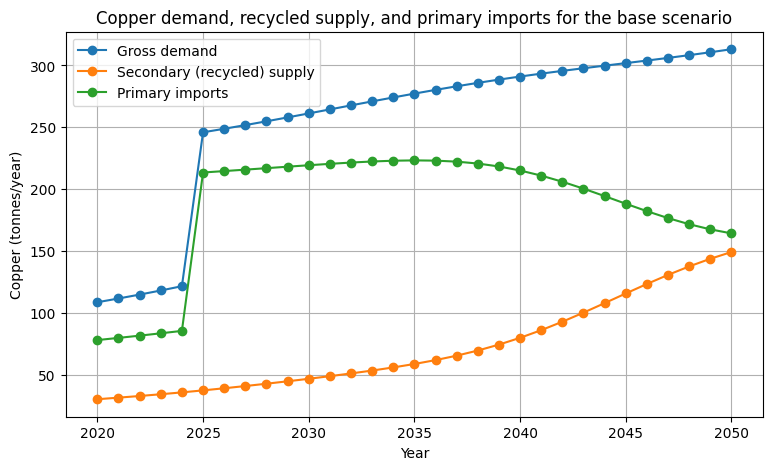

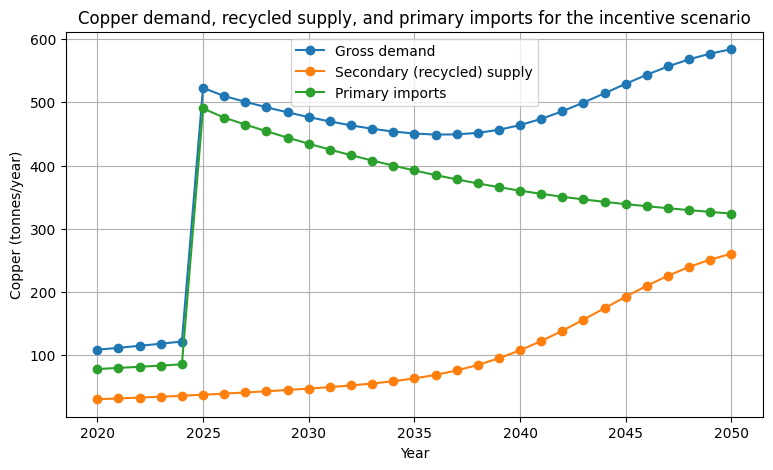

In [28]:
plt.figure(figsize=(9,5))
plt.plot(df_cu_base["year"], df_cu_base["Gross_demand_total"]/1000, marker="o")
plt.plot(df_cu_base["year"], df_cu_base["Secondary_total"]/1000, marker="o")
plt.plot(df_cu_base["year"], df_cu_base["Primary_imports_total"]/1000, marker="o")
plt.xlabel("Year")
plt.ylabel("Copper (tonnes/year)")
plt.title("Copper demand, recycled supply, and primary imports for the base scenario")
plt.legend(["Gross demand", "Secondary (recycled) supply", "Primary imports"])
plt.grid(True)
plt.show()


plt.figure(figsize=(9,5))
plt.plot(df_cu_inc["year"], df_cu_inc["Gross_demand_total"]/1000, marker="o")
plt.plot(df_cu_inc["year"], df_cu_inc["Secondary_total"]/1000, marker="o")
plt.plot(df_cu_inc["year"], df_cu_inc["Primary_imports_total"]/1000, marker="o")
plt.xlabel("Year")
plt.ylabel("Copper (tonnes/year)")
plt.title("Copper demand, recycled supply, and primary imports for the incentive scenario")
plt.legend(["Gross demand", "Secondary (recycled) supply", "Primary imports"])
plt.grid(True)
plt.show()

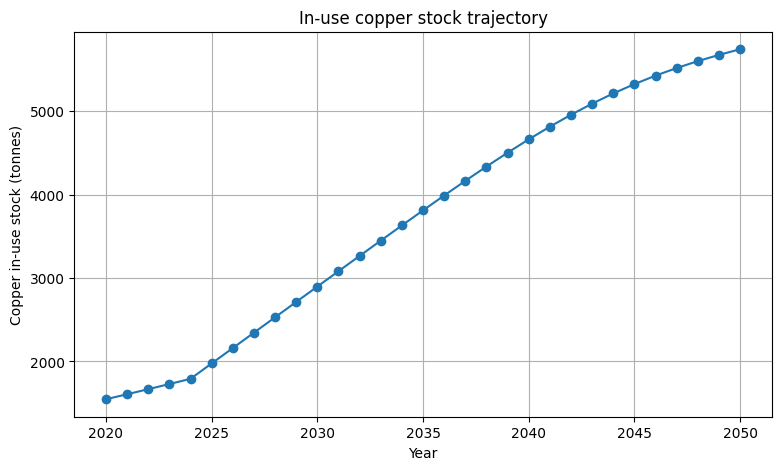

In [29]:
# in-use stock trajectory 
plt.figure(figsize=(9,5))
plt.plot(df_cu_base["year"], df_cu_base["Stock_total"]/1000, marker="o")
plt.xlabel("Year")
plt.ylabel("Copper in-use stock (tonnes)")
plt.title("In-use copper stock trajectory")
plt.grid(True)
plt.show()

## Copper Sankey


In [30]:
# GB copper stock: 11400 GB * 2.7kg = 307080 kg Cu = 307.8 tonn 
# # HP copper stock: 64 600 HP * 36 kg = 2 325.6 tonn 
# # HP stock is growing so increase each year is 
# # GB replacementrate + HP replacementrate + growing rate = 
# 4560 + 5000 + 440 = 10000 * 36kg = 360000 kg = 36 tonn 
# # Recycled GB = 0.61 * 4560 * 2.7kg # Recycled HP = 0.61 * 5000 * 36 kg 
# # Rest is outflow (waste)# Model values (tonnes)

#We chosse Copper_HP_s[35] as 2024 and same for GB
# We choose flow out as Copper_HP_o[35] same for GB

import plotly.graph_objects as go
import pandas as pd

rr = 0.61
hp_cu_out = Copper_HP_o[-26]/1000 # Going to waste
gb_cu_out = Copper_GB_o[-26]/1000


hp_to_cu = k*np.array(HP_DSM.o)[-26]*copper_HP/1000 # Recycled
gb_to_cu = k*np.array(GB_DSM.o)[-26]*copper_GB/1000

imports_to_cu = Copper_HP_i[-26]/1000 - k*np.array(GB_DSM.o)[-26]*copper_GB/1000 # Imported copper

gb_to_outflow = gb_cu_out
hp_to_outflow = hp_cu_out

cu_to_hp = imports_to_cu + gb_to_cu + hp_to_cu

print("Copper recycled from HP", hp_to_cu)
print("Copper recycled from GB", gb_to_cu)
print("Imports ", imports_to_cu)
print("Copper to waste from GB ", gb_cu_out)
print("Copper to waste from HP ", hp_cu_out)

ModuleNotFoundError: No module named 'plotly'

In [160]:

labels = [
    "Imports",                     # 0
    "GB Stock ",           # 1
    "HP Stock ",          # 2
    "Outflow (waste)"               # 3
]
sources = [
    0,  # Imports → HP
    1,  # GB → HP (recycling)
    1,  # GB → Outflow
    2,  # HP → HP (recycling loop)
    2   # HP → Outflow
]

targets = [
    2,  # Imports → HP
    2,  # GB → HP
    3,  # GB → Outflow
    2,  # HP → HP
    3   # HP → Outflow
]
values = [
    imports_to_cu,     # Imports → HP
    gb_to_cu,          # GB recycling → HP
    gb_to_outflow,     # GB waste
    hp_to_cu,          # HP recycling → HP
    hp_to_outflow      # HP waste
]
node_x = [
    0.25,  # Imports
    0.60,  # GB Stock
    0.45,  # HP Stock
    0.75   # Outflow
]

node_y = [
    0.50,  # Imports
    0.15,  # GB (top)
    0.50,  # HP (bottom)
    0.50   # Outflow
]
fig = go.Figure(go.Sankey(
    arrangement="fixed",
    node=dict(
        label=labels,
        x=node_x,
        y=node_y,
        pad=30,
        thickness=22,
        line=dict(color="black", width=0.6),
        color="rgba(120,120,120,0.4)"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[
            "rgba(80,130,255,0.7)",   # Imports → HP
            "rgba(60,180,200,0.7)",   # GB → HP
            "rgba(220,120,60,0.7)",   # GB → waste
            "rgba(60,170,100,0.7)",   # HP → HP (recycling)
            "rgba(220,120,60,0.7)"    # HP → waste
        ],
        hovertemplate="Flow: %{value:.2f} t<extra></extra>"
    )
))

annotations = [ dict(x=0.30, y=0.60, text=f"{imports_to_cu:.2f} t ->",showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.55, y=0.80, text=f"<- {gb_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.70, y=0.70, text=f"{gb_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.57, y=0.57, text=f"{hp_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
                dict(x = 0.45, y = 0.07, text=f"<- {hp_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black"))]

fig.update_layout(
    title=dict(
        text="Copper Flow Sankey – Direct Recycling into Heat Pumps (2024)",
        x=0.5
    ),
    font=dict(size=14),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = annotations
)
fig.show()


In [163]:
hp_cu_out = Copper_HP_o[-1]/1000 # Going to waste
gb_cu_out = Copper_GB_o[-1]/1000


hp_to_cu = k*np.array(HP_DSM.o)[-1]*copper_HP/1000 # Recycled
gb_to_cu = k*np.array(GB_DSM.o)[-1]*copper_GB/1000

imports_to_cu = Copper_HP_i[-1]/1000 - k*np.array(GB_DSM.o)[-1]*copper_GB/1000 # Imported copper

gb_to_outflow = gb_cu_out
hp_to_outflow = hp_cu_out

cu_to_hp = imports_to_cu + gb_to_cu + hp_to_cu
labels = [
    "Imports",                     # 0
    "GB Stock ",           # 1
    "HP Stock ",          # 2
    "Outflow (waste)"               # 3
]
sources = [
    0,  # Imports → HP
    1,  # GB → HP (recycling)
    1,  # GB → Outflow
    2,  # HP → HP (recycling loop)
    2   # HP → Outflow
]

targets = [
    2,  # Imports → HP
    2,  # GB → HP
    3,  # GB → Outflow
    2,  # HP → HP
    3   # HP → Outflow
]
values = [
    imports_to_cu,     # Imports → HP
    gb_to_cu,          # GB recycling → HP
    gb_to_outflow,     # GB waste
    hp_to_cu,          # HP recycling → HP
    hp_to_outflow      # HP waste
]
node_x = [
    0.25,  # Imports
    0.60,  # GB Stock
    0.45,  # HP Stock
    0.75   # Outflow
]

node_y = [
    0.50,  # Imports
    0.25,  # GB (top)
    0.50,  # HP (bottom)
    0.50   # Outflow
]
fig = go.Figure(go.Sankey(
    arrangement="fixed",
    node=dict(
        label=labels,
        x=node_x,
        y=node_y,
        pad=30,
        thickness=22,
        line=dict(color="black", width=0.6),
        color="rgba(120,120,120,0.4)"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[
            "rgba(80,130,255,0.7)",   # Imports → HP
            "rgba(60,180,200,0.7)",   # GB → HP
            "rgba(220,120,60,0.7)",   # GB → waste
            "rgba(60,170,100,0.7)",   # HP → HP (recycling)
            "rgba(220,120,60,0.7)"    # HP → waste
        ],
        hovertemplate="Flow: %{value:.2f} t<extra></extra>"
    )
))

annotations = [ dict(x=0.30, y=0.60, text=f"{imports_to_cu:.2f} t ->",showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.55, y=0.80, text=f"<- {gb_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.70, y=0.70, text=f"{gb_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")), 
                dict(x=0.57, y=0.60, text=f"{hp_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
                dict(x = 0.45, y = 0.07, text=f"<- {hp_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black"))]

fig.update_layout(
    title=dict(
        text="Copper Flow Sankey – Direct Recycling into Heat Pumps (2050)",
        x=0.5
    ),
    font=dict(size=14),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = annotations
)

fig.show()


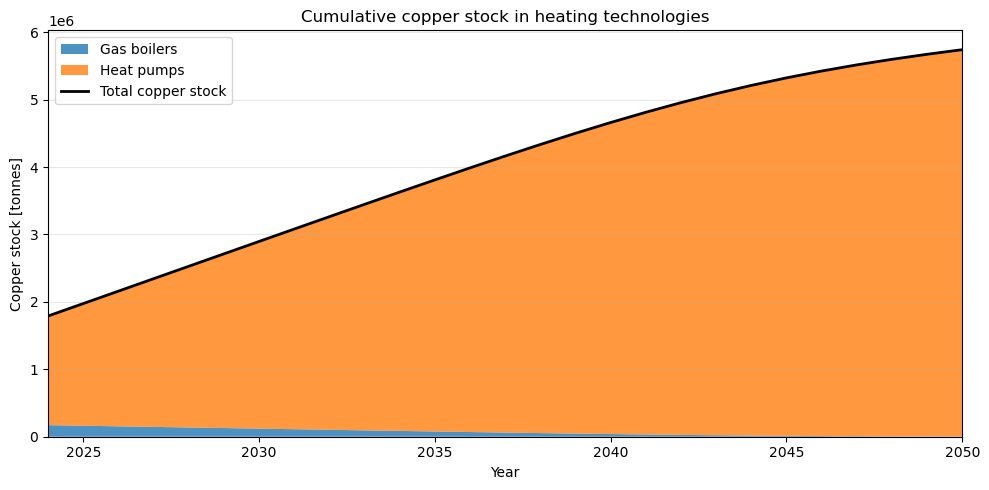

In [164]:
# Cummulative stock plot

t = np.arange(2024, 2051)

total_cu_stock = Copper_GB_s[-27:] + Copper_HP_s[-27:]
plt.figure(figsize=(10, 5))

plt.stackplot(
    t,
    Copper_GB_s[-27:],
    Copper_HP_s[-27:],
    labels=["Gas boilers", "Heat pumps"],
    alpha=0.8
)

plt.plot(
    t,
    total_cu_stock[-27:],
    color="black",
    linewidth=2,
    label="Total copper stock"
)

plt.xlabel("Year")
plt.ylabel("Copper stock [tonnes]")
plt.title("Cumulative copper stock in heating technologies")

plt.legend(loc="upper left")
plt.grid(True, axis="y", alpha=0.3)

plt.margins(x=0)               # 👈 removes gap
plt.xlim(t[0], t[-1])          # 👈 hard lock (optional but recommended)

plt.tight_layout()
plt.show()


# Sensitivity Analysis  

In [303]:

# Function to recalculate KPI 

def compute_kpis(COP_value, e_elec_value, efficiency_GB_value, e_gas_boiler_value):
 
  # DATA OF OUR MODEL 

  Years_HP = np.array(HP_DSM.t)                 #  1990–2050 
  HP_stock_base = np.array(HP_DSM.s)           
  HP_stock_inc  = np.array(HP_DSM_incentive.s)
  HP_in_base = np.array(HP_DSM.i)              # inflow HP baseline (nouvelles HP/an)
  HP_in_inc  = np.array(HP_DSM_incentive.i)    # inflow HP incitation

  
  years_GB_full = np.array(GB_DSM.t)           # Gas Boiler Years (2004–2050)
  GB_stock_full = np.array(GB_DSM.s)           # stock of GB 
  Years_GB = years_GB_full[20:]
  GB_stock = GB_stock_full[20:]

  # CALCULATION 

  elec_need_HP_per_house = S_household * cons_surface / COP_value

  Elec_imports_base = HP_stock_base * elec_need_HP_per_house / 1e6
  Elec_imports_inc  = HP_stock_inc  * elec_need_HP_per_house / 1e6

  # Emissions of HP AND GB [tCO2/an]
  
  CO2_HP_base = Elec_imports_base * 1000 * e_elec_value + HP_in_base * e_HP_manufacture
  CO2_HP_inc  = Elec_imports_inc  * 1000 * e_elec_value + HP_in_inc  * e_HP_manufacture

  CO2_GB_series = S_household*cons_surface / efficiency_GB_value * GB_stock * 3.6 * e_gas_boiler_value / 1000 #tCO2/year  # [tCO2/an]


  # Cumuls 2024–2050 

  mask_HP = Years_HP >= 2024
  mask_GB = Years_GB >= 2024

  CO2_HP_base_cum  = CO2_HP_base[mask_HP].sum()
  CO2_HP_inc_cum   = CO2_HP_inc[mask_HP].sum()
  CO2_GB_cum       = CO2_GB_series[mask_GB].sum()



  return {
    "CO2_HP_base_cum":  CO2_HP_base_cum,
    "CO2_HP_inc_cum":   CO2_HP_inc_cum,
    "CO2_GB_cum":       CO2_GB_cum,
  }


# One parameter at time 


In [304]:
def sensitivity_param(param_name, base_value, values_to_test):
    
    print(f"\nSensibility in function of: {param_name}")
    print(f"Base Value : {base_value:.4f}")
    print(f"Tested values : {', '.join(f'{v:.4f}' for v in values_to_test)}")

    
    results = []

    for val in values_to_test:
        # to change the god parameter 
        COP_test           = COP           if param_name != "COP"           else val
        efficiency_GB_test = efficiency_GB if param_name != "efficiency_GB" else val
        e_elec_test        = e_elec        if param_name != "e_elec"        else val
        e_gas_test         = e_gas_boiler  if param_name != "e_gas_boiler"  else val

        res = compute_kpis(COP_test, e_elec_test, efficiency_GB_test, e_gas_test)
        results.append((val, res))

    # TRUE KPI
    base_res = None
    for (val, res) in results:
        if abs(val - base_value) < 1e-9:
            base_res = res
            break

    if base_res is None:
        print("Warning: No value is the true base value.")
        return None
    
    CO2_base_HP_inc  = base_res["CO2_HP_inc_cum"]
    CO2_base_HP      = base_res["CO2_HP_base_cum"]
    CO2_base_GB      = base_res["CO2_GB_cum"]

    
    print("\nValue\t\tCO2_HP_inc (tCO2)\tΔ vs base\tCO2_HP_base (tCO2)\tΔ vs base\tCO2_GB (tCO2)\tΔ vs base")

    values_list       = []
    CO2_HP_inc_list   = []
    CO2_HP_base_list  = []
    CO2_GB_list       = []
    d_inc_list        = []
    d_base_list       = []
    d_GB_list         = []

    for (val, res) in results:
        CO2_HP_inc_cum = res["CO2_HP_inc_cum"]
        CO2_HP_cum     = res["CO2_HP_base_cum"]
        CO2_GB_cum     = res["CO2_GB_cum"]

        d_inc  = 100 * (CO2_HP_inc_cum  - CO2_base_HP_inc) / CO2_base_HP_inc  if CO2_base_HP_inc  != 0 else 0.0
        d_base = 100 * (CO2_HP_cum      - CO2_base_HP)     / CO2_base_HP      if CO2_base_HP      != 0 else 0.0
        d_GB   = 100 * (CO2_GB_cum      - CO2_base_GB)     / CO2_base_GB      if CO2_base_GB      != 0 else 0.0

        print(f"{val:.4f}\t{CO2_HP_inc_cum:12.0f}\t{d_inc:+6.1f} %\t"
              f"{CO2_HP_cum:12.0f}\t{d_base:+6.1f} %\t"
              f"{CO2_GB_cum:12.0f}\t{d_GB:+6.1f} %")

        
        values_list.append(val)
        CO2_HP_inc_list.append(CO2_HP_inc_cum)
        CO2_HP_base_list.append(CO2_HP_cum)
        CO2_GB_list.append(CO2_GB_cum)
        d_inc_list.append(d_inc)
        d_base_list.append(d_base)
        d_GB_list.append(d_GB)

    
    return {
        "param": param_name,
        "base_value": base_value,
        "values": values_list,
        "CO2_HP_inc": CO2_HP_inc_list,
        "CO2_HP_base": CO2_HP_base_list,
        "CO2_GB": CO2_GB_list,
        "d_CO2_HP_inc": d_inc_list,
        "d_CO2_HP_base": d_base_list,
        "d_CO2_GB": d_GB_list,
    }



factors = [0.8, 1.0, 1.2]

# Sensibility of parameters 
#  
COP_values = [f * COP for f in factors]
sens_COP= sensitivity_param("COP", COP, COP_values)

e_elec_values = [f * e_elec for f in factors]
sens_elec = sensitivity_param("e_elec", e_elec, e_elec_values)

eff_GB_values = [f * efficiency_GB for f in factors]
sens_effGB = sensitivity_param("efficiency_GB", efficiency_GB, eff_GB_values)

e_gas_values = [f * e_gas_boiler for f in factors]
sens_gas = sensitivity_param("e_gas_boiler", e_gas_boiler, e_gas_values)



Sensibility in function of: COP
Base Value : 3.2600
Tested values : 2.6080, 3.2600, 3.9120

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
2.6080	   476488703	  +0.0 %	   273029680	  +0.0 %	     1091368	  +0.0 %
3.2600	   476447342	  +0.0 %	   273004206	  +0.0 %	     1091368	  +0.0 %
3.9120	   476419768	  -0.0 %	   272987223	  -0.0 %	     1091368	  +0.0 %

Sensibility in function of: e_elec
Base Value : 0.0273
Tested values : 0.0218, 0.0273, 0.0328

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.0218	   476414253	  -0.0 %	   272983827	  -0.0 %	     1091368	  +0.0 %
0.0273	   476447342	  +0.0 %	   273004206	  +0.0 %	     1091368	  +0.0 %
0.0328	   476480431	  +0.0 %	   273024586	  +0.0 %	     1091368	  +0.0 %

Sensibility in function of: efficiency_GB
Base Value : 0.9000
Tested values : 0.7200, 0.9000, 1.0800

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.7200

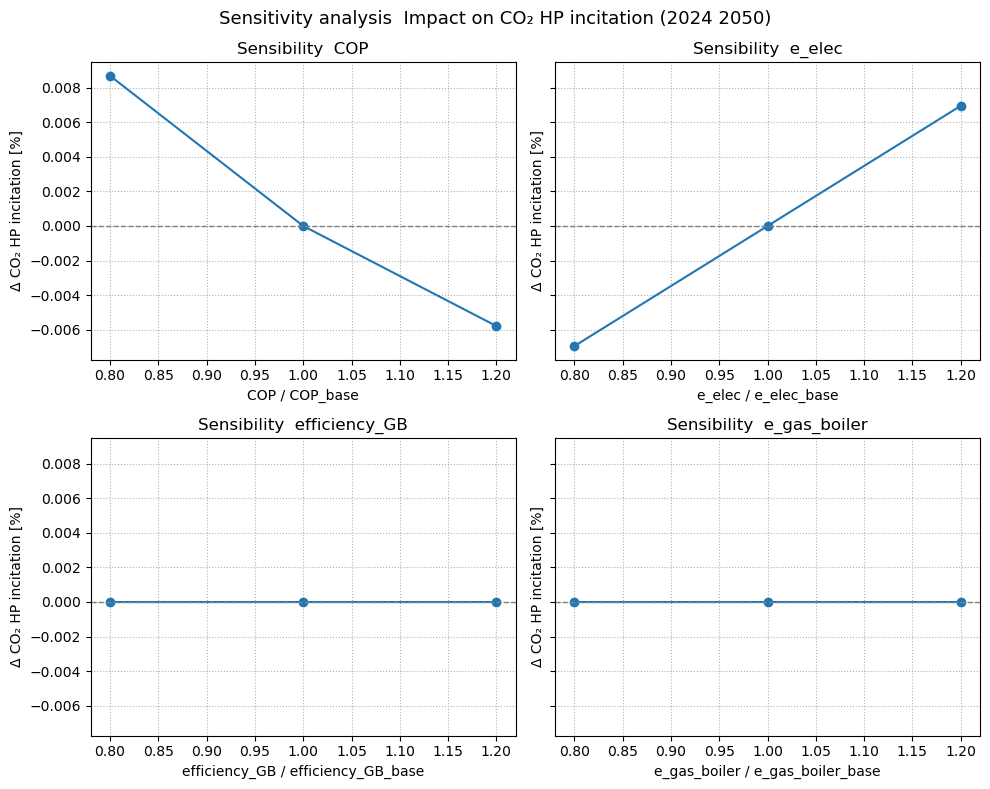

In [305]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_inc"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ HP incitation (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()




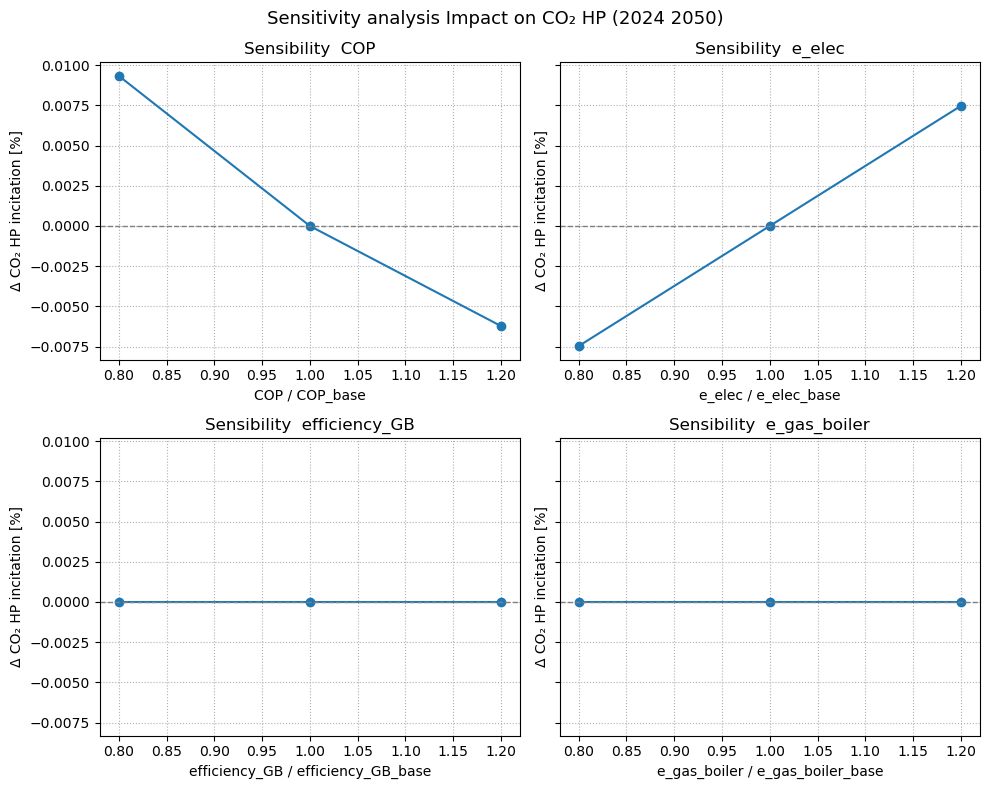

In [306]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_base"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis Impact on CO₂ HP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()

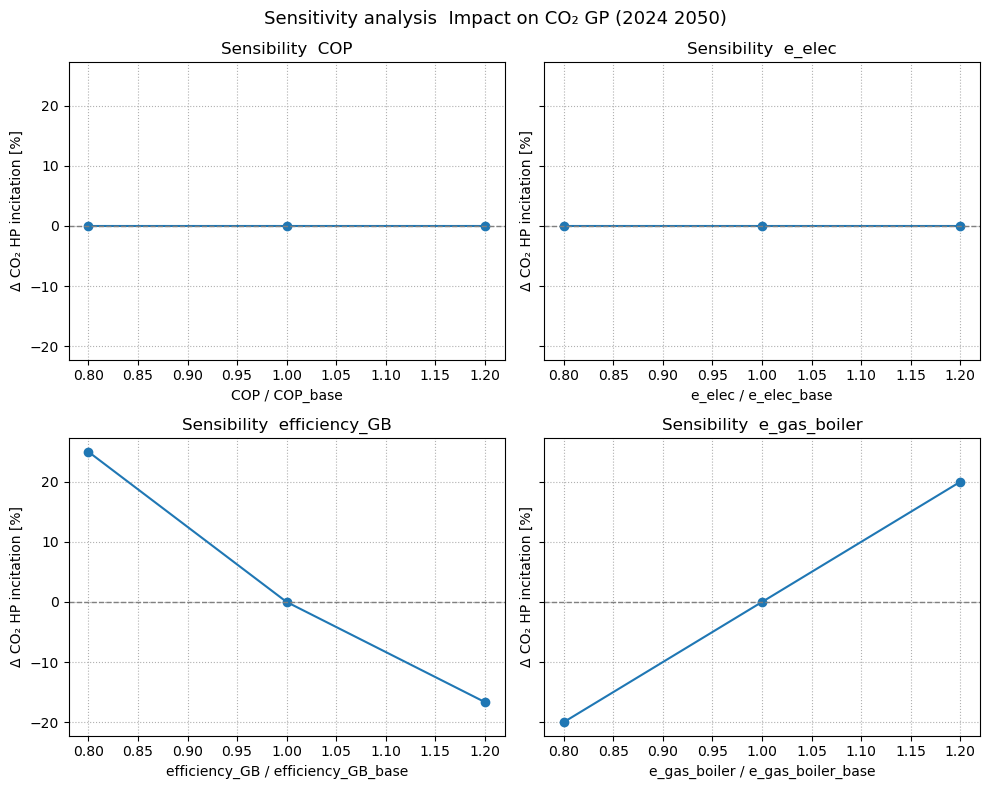

In [307]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_GB"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ GP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()

In [308]:
def compute_kpis_copper(k_value, copper_HP_value, copper_GB_value):

 
    # HP baseline
    Cu_HP_imports = np.array(HP_DSM.i) * copper_HP_value     
    Cu_HP_stock   = np.array(HP_DSM.s) * copper_HP_value      
    Cu_HP_exports = np.array(HP_DSM.o)  * copper_HP_value

    # HP incitation
    Cu_HP_inc_imports = np.array(HP_DSM_incentive.i) * copper_HP_value
    Cu_HP_inc_stock   = np.array(HP_DSM_incentive.s) * copper_HP_value
    Cu_HP_inc_exports = np.array(HP_DSM_incentive.o) * copper_HP * (1-k)

    # GB 
    Cu_GB_imports = np.array(GB_DSM.i) * copper_GB_value
    Cu_GB_exports = np.array(GB_DSM.o) * copper_GB_value * (1 - k_value)
    Cu_GB_stock   = np.array(GB_DSM.s) * copper_GB_value

    Cu_imports_total = Cu_HP_imports.sum() + Cu_HP_inc_imports.sum() + Cu_GB_imports.sum() - (np.array(GB_DSM.o) * copper_GB_value *  k_value).sum() - (np.array(HP_DSM_incentive.o) * copper_HP * k).sum() #the copper we reuse for recovering is no need to import 
    Cu_exports_total = Cu_GB_exports.sum() + Cu_HP_inc_exports.sum() + Cu_HP_exports.sum()
    Cu_stock_final   = Cu_HP_stock[-1] + Cu_HP_inc_stock[-1] + Cu_GB_stock[-1]

    return {
        "Cu_imports_total": Cu_imports_total,
        "Cu_exports_total": Cu_exports_total,
        "Cu_stock_final":   Cu_stock_final,
    }
# Copper stocks

Copper_HP_o=(1-k)*np.array(HP_DSM.s)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP

In [309]:
def sensitivity_copper(param_name, base_value, values_to_test):
  
    results = []

    for val in values_to_test:
        k_test      = k          if param_name != "k"          else val
        Cu_HP_test  = copper_HP  if param_name != "copper_HP"  else val
        Cu_GB_test  = copper_GB  if param_name != "copper_GB"  else val

        kpis = compute_kpis_copper(k_test, Cu_HP_test, Cu_GB_test)
        results.append(kpis)
    base_idx  = len(values_to_test) // 2  
    base_kpis = results[base_idx]

    return {
        "param":   param_name,
        "values":  values_to_test,
        "imports": [r["Cu_imports_total"] for r in results],
        "exports": [r["Cu_exports_total"] for r in results],
        "stock":   [r["Cu_stock_final"]   for r in results],
        "base":    base_kpis,
    }

factors = [0.8, 1.0, 1.2]

results_k  = sensitivity_copper("k", k, [f * k for f in factors])
results_HP = sensitivity_copper("copper_HP", copper_HP, [f * copper_HP for f in factors])
results_GB = sensitivity_copper("copper_GB", copper_GB, [f * copper_GB for f in factors])

print("k:", results_k)
print("copper_HP:", results_HP)
print("copper_GB:", results_GB)

k: {'param': 'k', 'values': [0.488, 0.61, 0.732], 'imports': [np.float64(21624430.01022561), np.float64(21588103.415170707), np.float64(21551776.820115797)], 'exports': [np.float64(6026343.468648404), np.float64(5990016.8735935), np.float64(5953690.278538596)], 'stock': [np.float64(15598086.541577209), np.float64(15598086.541577209), np.float64(15598086.541577209)], 'base': {'Cu_imports_total': np.float64(21588103.415170707), 'Cu_exports_total': np.float64(5990016.8735935), 'Cu_stock_final': np.float64(15598086.541577209)}}
copper_HP: {'param': 'copper_HP', 'values': [20.0, 25.0, 30.0], 'imports': [np.float64(16652799.404136037), np.float64(21588103.415170707), np.float64(26523407.42620538)], 'exports': [np.float64(5225305.741694811), np.float64(5990016.8735935), np.float64(6754728.005492189)], 'stock': [np.float64(12478947.618089795), np.float64(15598086.541577209), np.float64(18717225.465064622)], 'base': {'Cu_imports_total': np.float64(21588103.415170707), 'Cu_exports_total': np.flo

<Figure size 700x500 with 0 Axes>

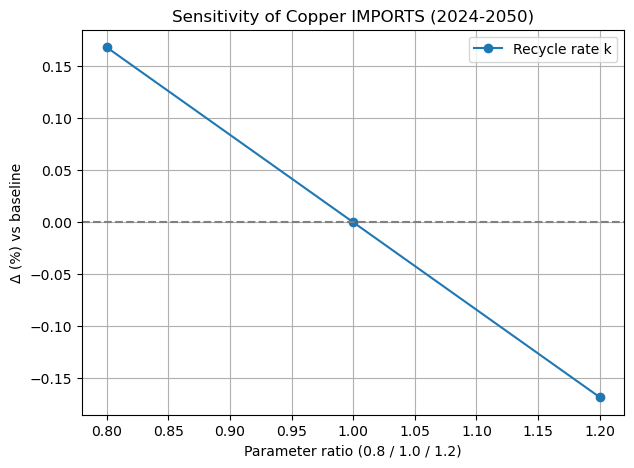

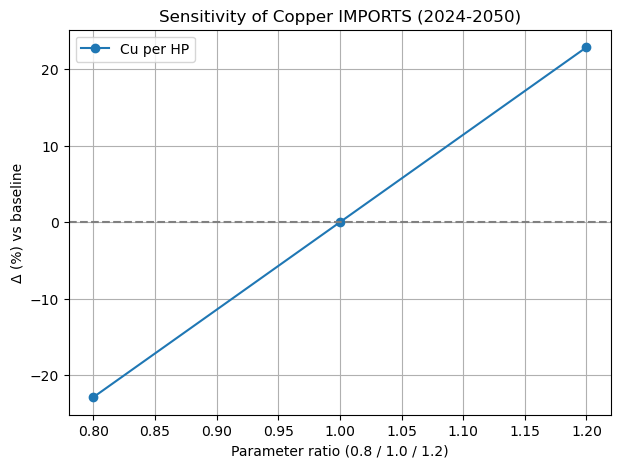

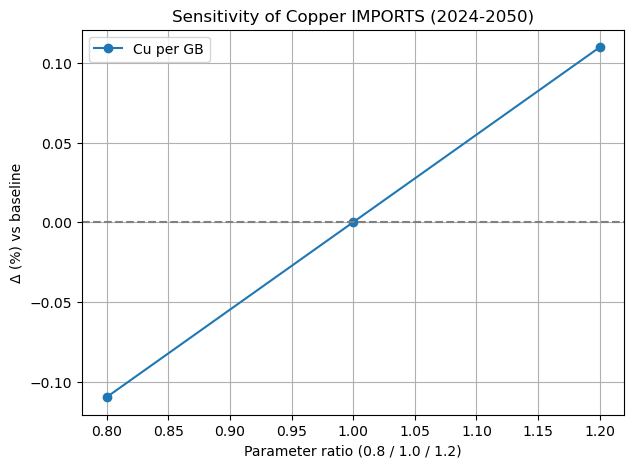

In [310]:
# ----- Parameters -----
kpi_name = "imports"   # "imports", "exports", "stock"


if kpi_name == "imports":
    key = "Cu_imports_total"
elif kpi_name == "exports":
    key = "Cu_exports_total"
elif kpi_name == "stock":
    key = "Cu_stock_final"


plt.figure(figsize=(7,5))

labels = {"k":"Recycle rate k", "copper_HP":"Cu per HP", "copper_GB":"Cu per GB"}
params = [results_k, results_HP, results_GB]

for res in params:

    base = res["base"][key]

    
    tested_values = res[kpi_name]     # ex : res["imports"]

    
    deltas = [(v - base)/base * 100 for v in tested_values]

    plt.figure(figsize=(7,5))
    plt.plot([0.8, 1.0, 1.2], deltas, marker="o", label=labels[res["param"]])

    plt.axhline(0, color="gray", linestyle="--")
    plt.title(f"Sensitivity of Copper {kpi_name.upper()} (2024-2050)")
    plt.xlabel("Parameter ratio (0.8 / 1.0 / 1.2)")
    plt.ylabel("Δ (%) vs baseline")
    plt.grid(True)
    plt.legend()
    plt.show()